# Trabalho de Computação - Xadrez Python
### Autores: Alan Gayger, Diogo Sánchez e Pedro Werneck

## Relatório
- Visto a necessidade da criação de um trabalho prático para a composição da nota da A2 da matéria de Computação, nosso grupo decidiu criar um xadrez em Python. Decidimos pela realização de tal projeto devido a uma sugestão do professor feita em aula e pelo nosso gosto pessoal pelo sofrimento. Isto posto, o código divide-se em três partes principais: auxiliar, estratégias e jogo.
- A parte auxiliar é composta pela importação de pacotes e definição de funções de suporte para o restante do código. Alguns exemplos são: funções que traduzem inputs e outputs, preparam matrizes, verificam jogadas, etc.
- A parte de estratégias é definida por funções que buscam pontuar um jogo e escolher jogadas segundo o método minmax. Esse método utiliza-se das pontuações supracitadas para determinar qual é a "melhor" jogada para um bot em um dado momento do jogo.
- A parte do jogo é definida pelas classes responsáveis pela execução do jogo, sendo possível ajustar e apreciar um duelo entre bots. Além disso, essa parte também gera imagens do tabuleiro no decorrer do jogo.



## Almanaque do Xadrez Python
- Variáveis:
    - tabuleiro_vazio - matriz 8x8 formada por listas de strings que representam as coordenadas de um tabuleiro de xadrez
    - jogo_start - matriz 8x8 formada por listas de strings que representam as peças de um tabuleiro de xadrez:
        - Prefixos: Ne (negras) , Br (brancas);
        - Sufixos: P (peão), C (cavalo), T (torre), D (dama), R (rei), B (bispo)
- Funções:
    - TraduzLinha() - Traduz notação do simulador para notação do pacote chess (usado para criar representações gráficas).
    - PlotaJogo() - Retorna imagem em svg do tabuleiro informado.
    - let_num() - traduz coordenada informada para notação matricial (tabuleiro utilizado no jogo)
    - movimento() - recebe um tabuleiro e um movimento (em número de casas a serem deslocadas), retornando um tabuleiro novo com o movimento aplicado sobre o antigo
    - destino() - recebe número de casas a ser movimento e posição inicial e retornam a casa em que a peça chegará
    - search_peca() - recebe as coordenadas de uma posição e um tabuleiro e retorna qual a peça na posição informada
    - apenas_dentro_tabuleiro() - recebe uma lista de movimentos e elimina todos aqueles que ultrapassam os limites do tabuleiro
    - anti_sobreposicao() - recebe uma lista de movimentos e elimina todos aqueles que sobrepõe uma peça de mesma cor
    - jogadas_possiveis() - verifica todos os lances legais possíveis pra um jogo (incluindo alguns lances ilegais)
    - cheque() - indica se o jogo está em xeque
    - cheque_mate() - indica se o jogo está em xeque-mate
    - jogadas_possiveis_2() - verifica todos os lances legais possíveis pra um jogo 
    - afogado() - verifica se o jogo está afogado
    - pontuacao() - atribui pontuações a quatro variáveis de um jogo de xadrez:
        - centralidade - domínio do centro
        - liberdade - liberdade das peças
        - peças - pontuação das peças
        - ameaçador - nível de ameaça às peças do adversário
    - futuro() - recebe um tabuleiro e uma cor, retornando as melhores jogadas (top 10%) e a pontuação de cada resultado possível 
    - jogada_adv() - retorna as melhores jogadas para o adversário
    - futuro_1play() - retorna a melhor jogada considerando resposta adversária
    - code_to_move() - traduz saída da futuro_1play() ("G2^[1,1]" --> "G2H3")
    - movimento1() - recebe um tabuleiro e um movimento (coordenada do tabuleiro em notação textual), retornando um tabuleiro novo com o movimento aplicado sobre o antigo
    - rock_grande() - executa o roque grande em um tabuleiro
    - rock_pequeno() - executa o roque pequeno em um tabuleiro
- Classes:
    - Chess_pc_pc() - prepara um jogo "máquina vs. máquina"
        - método - play() - recebe dois vetores de tamanho 4 que definem a estratégias utilizadas pelos bots (peso dado a cada componente da pontuação) e roda o tabuleiro frame a frame
    - Chess_human_bot() - prepara um jogo "humano vs. máquina"
        - método - play() - recebe um vetor de tamanho 4 que define a estratégia utilizada pelo bot (peso dado a cada componente da pontuação) e roda o tabuleiro frame a frame

### Simulador

In [4]:
# Importando Pacotes

import copy
import numpy as np
from functools import reduce
import chess
from IPython.display import display,clear_output
import time

In [5]:
def TraduzLinha(lista):
    """
    Retorna linha do tabuleiro recebida "traduzida" para ser utilizada pelo pacote chess.
    lista: recebe lista contendo strings das peças em uma dada linha do tabuleiro, representando a linha do tabuleiro. 
    """
    
    
    # salva índices das casas não vazias na linha
    indices = [coluna for coluna in range(len(lista)) if lista[coluna] != '']
    string_linha = ''
    
    # transforma a linha em string, concatenando peças e indicando quantas casas vazias há entre elas
    # exemplo: se lista = ['', '', 'NeP', '', 'NeD', '', '', ''], então a string será 2NeP1NeD3
    for posicao in range(len(indices)):
        if posicao == 0:
            string_linha += str(indices[posicao]) + lista[indices[posicao]]
            if posicao == len(indices) - 1:
                string_linha += str(7 - indices[-1]) 
        elif indices[-1] == 7:
            string_linha += str(indices[posicao] - indices[posicao - 1] - 1) + lista[indices[posicao]]
        else:
            string_linha += str(indices[posicao] - indices[posicao - 1] - 1) + lista[indices[posicao]]
            if posicao == len(indices) - 1:
                string_linha += str(7 - indices[-1])

    # retira zeros indesejados da string
    string_linha = string_linha.replace('0','')
    
    # substitui linhas vazias pela indicação de que há 8 casas vazias
    if string_linha == '':
        string_linha = '8'
        
    return string_linha
    

def PlotaJogo(tabuleiro):
    """
    Retorna imagem do tabuleiro informado.
    tabuleiro: recebe tabuleiro do jogo em um determinado momento da partida.
    """
    
    
    # define "tradução" das peças do jogo do simulador para serem utilizadas pela biblioteca chess
    dicio_jogo = {'NeT':'r', 'NeC':'n', 'NeB':'b', 
                  'NeD':'q', 'NeR':'k', 'NeP':'p', 
                  'BrT':'R', 'BrC':'N', 'BrB':'B', 
                  'BrD':'Q', 'BrR':'K', 'BrP':'P'}
    lista_jogo = []
    
    # aplica função TraduzLinha, a todas as linhas do tabuleiro
    for linha in range(len(tabuleiro)):
        lista_jogo.append(TraduzLinha(tabuleiro[linha]))

    # junta linhas de lista_jogo em uma única string
    string_jogo = '/'.join(lista_jogo)

    # substitui nomes de peças dados pelas chaves de dicio_jogo pelos nomes dados pelos valores
    # (traduzidos pra biblioteca chess)
    for chave, valor in dicio_jogo.items():
        string_jogo = string_jogo.replace(chave, valor)
        
    # retorna imagem do tabuleiro
    return chess.Board(string_jogo)
    

    

In [6]:
# Cria tabuleiro com as posições de cada uma das casas (com formato A-H,1-8)

letras=['A','B','C','D','E','F','G','H']
tabuleiro_vazio=[]

# varre todos os números e todas as letras para formar o tabuleiro
for numero in range(7,-1,-1):
    linha=[]
    for letra in letras:
        linha.append(letra + str(numero + 1))
    tabuleiro_vazio.append(linha)
    
tabuleiro_vazio

[['A8', 'B8', 'C8', 'D8', 'E8', 'F8', 'G8', 'H8'],
 ['A7', 'B7', 'C7', 'D7', 'E7', 'F7', 'G7', 'H7'],
 ['A6', 'B6', 'C6', 'D6', 'E6', 'F6', 'G6', 'H6'],
 ['A5', 'B5', 'C5', 'D5', 'E5', 'F5', 'G5', 'H5'],
 ['A4', 'B4', 'C4', 'D4', 'E4', 'F4', 'G4', 'H4'],
 ['A3', 'B3', 'C3', 'D3', 'E3', 'F3', 'G3', 'H3'],
 ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'H2'],
 ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1']]

In [7]:
# tabuleiro com cada uma das peças em suas posições inicias
# Ne - negras, Br - brancas
# T - torre, C - cavalo, B - bispo, D - dama, R - rei

jogo_start=[['NeT', 'NeC', 'NeB', 'NeD', 'NeR', 'NeB', 'NeC', 'NeT'],
 ['NeP', 'NeP', 'NeP', 'NeP', 'NeP', 'NeP', 'NeP', 'NeP'],
 ['', '', '', '', '', '', '', ''],
 ['', '', '', '', '', '', '', ''],
 ['', '', '', '', '', '', '', ''],
 ['', '', '', '', '', '', '', ''],
 ['BrP', 'BrP', 'BrP', 'BrP', 'BrP', 'BrP', 'BrP', 'BrP'],
 ['BrT', 'BrC', 'BrB', 'BrD', 'BrR', 'BrB', 'BrC', 'BrT']]

jogo_start

[['NeT', 'NeC', 'NeB', 'NeD', 'NeR', 'NeB', 'NeC', 'NeT'],
 ['NeP', 'NeP', 'NeP', 'NeP', 'NeP', 'NeP', 'NeP', 'NeP'],
 ['', '', '', '', '', '', '', ''],
 ['', '', '', '', '', '', '', ''],
 ['', '', '', '', '', '', '', ''],
 ['', '', '', '', '', '', '', ''],
 ['BrP', 'BrP', 'BrP', 'BrP', 'BrP', 'BrP', 'BrP', 'BrP'],
 ['BrT', 'BrC', 'BrB', 'BrD', 'BrR', 'BrB', 'BrC', 'BrT']]

In [8]:
# Movimentos das peças
# cada variável corresponde a uma peça e contém uma lista de possíveis posições para as quais a peça pode deslocar-se 
# (partindo-se uma posição qualquer no tabuleiro)

rei=[[-1, -1], [-1, 0], [-1, 1], [0, -1], [0, 0], [0, 1], [1, -1], [1, 0], [1, 1]]
cavalo=[[2, 1], [1, 2], [2, -1], [-1, 2], [-2, 1], [1, -2], [-2, -1], [-1, -2]]

# cria movimentos para torre em tuplas (por objetividade)
torre=[ ([i,0],[0,i]) for i in range(-8,9)]
# organiza movimentos em uma única lista, padronizando-os com os movimentos de outras peças
torre=[i[0] for i in torre]+[i[1] for i in torre] #Por Default

# mesmo procedimento que em torre
bispo=[[i,i] for i in range(-8,9)]
bispo+=[[i,-i] for i in range(-8,9)] #por default

dama=torre+bispo #por default

peao_b=[[1,0],[2,0]]
peao_n=[[-1,0],[-2,0]] 

In [9]:
# tradução de casas em posições no tabuleiro

def let_num(texto):
    """
    Retorna posição da casa informada em texto na lista que forma o tabuleiro.
    texto: string com casa do tabuleiro (exemplo: "E1").
    """
    
    i=letras.index(texto[0])
    j=8-int(texto[1])
    return j,i

print(let_num('E1'))
print(jogo_start[7][4])




(7, 4)
BrR


In [10]:
def movimento(posicao,linhas,colunas,jogo):
    """
    Aplica o movimento atualizando a matriz jogo.
    posicao: indica posição da peça a ser movida.
    linhas: indica de quantas linhas a peça deve ser deslocada.
    colunas: indica de quantas colunas a peça deve ser deslocada.
    jogo: recebe tabuleiro no qual se deseja realizar o movimento.
    """
  
    jogo1=[i[:] for i in copy.deepcopy(jogo)]

    i,j=let_num(posicao) # pega a posição em texto e transforma pra número
    peca=jogo1[i][j] # salva a peça
    jogo1[i][j]="" # apaga a peça
    
    # determina novas coordenadas da peça escolhida
    i-=linhas
    j+=colunas
    jogo1[i][j]=peca #coloca a peça
    return jogo1 #retorna o novo jogo

a=movimento('G1',2,-1,jogo_start)
#Cavalo de G1 pra F3 
#for i in jogo_start:
#    print(i)

In [11]:
def destino(posicao,linhas,colunas):
    """
    Retorna a casa de destino, dada uma posição inicial e a quantidade de linhas e colunas a serem deslocadas.
    posicao: indica uma posição no tabuleiro.
    linhas: indica de quantas linhas a peça deve ser deslocada.
    colunas: indica de quantas colunas a peça deve ser deslocada.
    """
    
    if posicao == "":
        return ""

    i,j=let_num(posicao) # pega a posição em texto e transforma pra número

    i-=linhas
    j+=colunas
    
    if i > 7 or j>7 or i<0 or j<0:
        return ""
    else:
        return tabuleiro_vazio[i][j] #retorna nova posição

In [12]:
destino("G1",2,-1)

'F3'

In [13]:
def search_peca(posicao,jogo,cor=False):
    """
    Retorna a peça que está na posição indicada dado o tabuleiro contido em jogo.
    posicao: indica posição de uma casa no tabuleiro.
    jogo: recebe tabuleiro com uma determinada configuração de jogo.
    cor: se True, retorna cor da peça, se False, retorna peça.
    """
    
    if len(posicao)!=2:
        return ""
    i,j=let_num(posicao)
    
    # retorna cor (se cor == True)
    if cor==True:
        if jogo[i][j]=="":
            pass
        else:
            return jogo[i][j][0]

    return jogo[i][j]

In [14]:
def apenas_dentro_tabuleiro(posicao,lista):
    """
    Dada uma lista de movimentos possiveis (linhas e colunas) e uma posição inicial, essa função elimina todas que estão fora do tabuleiro.
    posicao: recebe posição da peça a ser analisada.
    lista: recebe lista com movimentos possíveis da peça a ser analisada.
    """
    
    retorno=[]

    for x,y in lista:
        if destino(posicao,x,y)!="": # verifica se o destino da peça está fora do tabuleiro
            retorno.append([x,y])
    return retorno
    

def anti_sobreposicao(jogo,posicao:str,conjunto:list):
    """
    Dada uma lista de possíveis movimentos, a função elimina movimentos que causariam sobreposição (peça branca em cima de peça branca).
    jogo: recebe tabuleiro de um jogo com uma determinada configuração.
    posicao: posição da peça a ser analisada.
    conjunto: lista com possíveis movimentos da peça analisada.
    """
    
    # encontra peça na posição indicada e sua cor
    jogo1=[i[:] for i in copy.deepcopy(jogo)]
    peca=search_peca(posicao,jogo1)
    cor=peca[0]
    retorno=[]
    
    # verifica se nova posição da peça indicada contém outra peça de mesma cor
    for x,y in conjunto:
        if search_peca(destino(posicao,x,y),jogo1,True)!=cor:
            retorno.append([x,y])
    return retorno


In [15]:
def jogadas_possiveis(posicao:str,jogo:list,tipo=int):
    """
    Verifica jogadas possíveis para peça na posição indicada (retorna lista de posições possíveis para a jogada).
    posicao: indica posição da peça a ser analisada.
    jogo: recebe tabuleiro com um jogo de determinada configuração.
    tipo: se int, retorna a lista de jogadas possíveis em formato inteiro. Se str, retorna a lista em formato string.
    """
    
    # copia o jogo e seleciona a peça e a sua cor
    jogo1=[i[:] for i in copy.deepcopy(jogo)]
    i,j=let_num(posicao)
    peca=jogo1[i][j]
    
    if peca=="":
        return []
    cor=peca[0] 
    conjunto=[]
    
    # atribui lista "conjunto" os possíveis movimentos da peça analisada
    
    if peca[-1]=='R':#Rei
        conjunto=rei


    elif peca[-1]=='C': #Cavalo
        conjunto=cavalo


    elif peca[-1]=='P': #Peão
        if cor =='N':
            conjunto=[]
            if search_peca(destino(posicao,-1,0),jogo1)=="": # peão negro desce uma casa vazia
                conjunto.append([-1,0])

            if search_peca(destino(posicao,-2,0),jogo1)=="" and posicao[1] in ['7','2'] and search_peca(destino(posicao,-1,0),jogo1)=="":
                conjunto.append([-2,0])

            if search_peca(destino(posicao,-1,-1),jogo1).startswith('Br'): # peão negro mata uma peça na diagonal
                conjunto.append([-1,-1])

            if search_peca(destino(posicao,-1,1),jogo1).startswith('Br'): # peão negro mata uma peça na diagonal
                conjunto.append([-1,1])


        elif cor == 'B':
            conjunto=[]
            if search_peca(destino(posicao,1,0),jogo1)=="":
                conjunto.append([1,0])

            if search_peca(destino(posicao,2,0),jogo1)=="" and posicao[1] in ['7','2'] and search_peca(destino(posicao,1,0),jogo1)=="":
                conjunto.append([2,0])
                
            if search_peca(destino(posicao,1,1),jogo1).startswith('Ne'):
                conjunto.append([1,1])

            if search_peca(destino(posicao,1,-1),jogo1).startswith('Ne'):
                conjunto.append([1,-1])
        
        if not let_num(posicao)[0] in [1,6]:
            conjunto=[[x,y] for x,y in conjunto if abs(x)<2 and abs(y)<2]
        

    if peca[-1] in ['T','D']: #Torre ou dama
        vertical=[]
        
        for num in range(0,8,1): #sobe VERT
            if num ==0: 
                continue
            # interrompe adição de casas às possibilidades de movimento ao encontrar uma peça em uma determinada casa
            if search_peca(destino(posicao,num,0),jogo1) != "":
                vertical.append([num,0])
                break
            # adiciona casas às possibilidades de movimento enquanto não há interrupção
            else:
                vertical.append([num,0])

        for num in range(0,-8,-1): #desce VER
            if num ==0:
                continue
            
            if search_peca(destino(posicao,num,0),jogo1) != "": #B
                vertical.append([num,0])
                break
            else:
                vertical.append([num,0])

        for num in range(0,8,1): #HORI a direita
            if num ==0:
                continue
            
    
            if search_peca(destino(posicao,0,num),jogo1) != "":
                vertical.append([0,num])
                break
            else:
                vertical.append([0,num])
        

        for num in range(0,-8,-1): #HORI a esuerda
            if num ==0:
                continue
            
            if search_peca(destino(posicao,0,num),jogo1) != "":
                vertical.append([0,num])
                break
            else:
                vertical.append([0,num])
                
        conjunto=[i[:] for i in vertical[:]]

    

    if peca[-1] in ['B','D']: #bispo ou dama
        vertical=[]
        
        # p recebe quantas casas na diagonal a peça pode se mover, em um determinado quadrante, sem sair do tabuleiro
        p1 = min(i+1,8-j)
        p2 = min(i+1,j+1)
        p3 = min(j+1,8-i)
        p4 = min(8-j,8-i)
        
        for num in range(0,p1,1): #1º quadrante
            if num ==0:
                continue
            # mesmo funcionamento que para torre e dama
            vertical.append([num,num])
            if search_peca(destino(posicao,num,num),jogo1) != "":
                break

        for num in range(0,p2): #2º quadrante
            if num ==0:
                continue
            vertical.append([num,-num])
            if search_peca(destino(posicao,num,-num),jogo1) != "":
                break

        for num in range(0,p3): #3º quadrante
            if num ==0:
                continue
            vertical.append([-num,-num])
            if search_peca(destino(posicao,-num,-num),jogo1) != "":
                break

        for num in range(0,p4,1): #4º quadrante
            if num ==0:
                continue
            vertical.append([-num,num])
            if search_peca(destino(posicao,-num,num),jogo1) != "":
                break
        conjunto+=vertical

    # elimina movimentos que saem do tabuleiro e que sobrepõe peças de mesma cor
    conjunto=apenas_dentro_tabuleiro(posicao,conjunto)
    conjunto=anti_sobreposicao(jogo1,posicao,conjunto)
    conjunto=[i for i in conjunto if not i==""] 
    
    if tipo==str:
        conjunto=[ destino(posicao,x,y) for x,y in conjunto ] # repassa jogadas possíveis para formato string (casas do tabuleiro)

    if len(conjunto)==0:
        conjunto.append("")
    return conjunto




In [16]:
def cheque(jogo_de_entrada,vitima):
    """
    Retorna True se o jogador informado em vitima estiver em cheque.
    jogo_de_entrada: recebe jogo a ser analisado.
    vitima: recebe a cor do jogador que é possível vítima de cheque.
    """
    
    jogo=[i[:] for i in copy.deepcopy(jogo_de_entrada)]
    vitima=vitima.upper()
    # especifica qual é o jogador a dar o xeque (adversario)
    if vitima[0]=='N':
        rei_,adversario='NeR','B'
    else:
        rei_,adversario='BrR','N'

    # adiciona todas as peças do jogador a dar cheque em tabuleiro
    tabuleiro=[]
    for i in tabuleiro_vazio:
            tabuleiro+=i
    
    # peças do adversário
    casas_adv = [i for i in tabuleiro if search_peca(i,jogo).startswith(adversario)] 
    # um adversário pode te tocar

    casas=[]
    # casas recebe cada um dos movimentos possíveis de cada uma das peças do adversário 
    for posicao in casas_adv:
        casas += jogadas_possiveis(posicao,jogo,str)
    # se alguma das posições em casas sobrepor o rei inimigo, então ocorre o xeque
    for i in casas:
        if search_peca(i,jogo)==rei_:
            return True
            
            
    return False


In [17]:
def cheque_mate(jogo_de_entrada, cor='Ambas'):
    
    jogo=[i[:] for i in copy.deepcopy(jogo_de_entrada)]

    tabuleiro=[]
    for i in tabuleiro_vazio:
        tabuleiro+=i

    olhar_geral=[True,True]
    
    #olhando pras negras
    tabuleiro1=[i[:] for i in tabuleiro[:]]

    for posicao in tabuleiro:
        i,j=let_num(posicao)
        peca=jogo[i][j]
        # essa parte do código não faz nada, é só retirar
        if peca=="":
            continue    
        if peca[0]=='N':
            # registra todos os movimentos possíveis das peças negras
            movimentos_possiveis=jogadas_possiveis(posicao,jogo,int)
            if movimentos_possiveis[0]=="":
                continue
            
            else:
                # verifica se algum dos movimentos possíveis gera cheque (negras em cheque)
                for mov in movimentos_possiveis:
                    tabuleiro=movimento(posicao,mov[0],mov[1],jogo)
                    if cheque(tabuleiro,'Negras')==False:
                        olhar_geral[0]=False
                        break
        else:
            continue
            
    tabuleiro=tabuleiro1.copy()
    
    # Olhando pras brancas (mesmo procedimento de negras)
    for posicao in tabuleiro:
        i,j=let_num(posicao)
        peca=jogo[i][j]
        if peca=="":
            continue
        if peca[0]=='B':
            movimentos_possiveis=jogadas_possiveis(posicao,jogo,int)
            if movimentos_possiveis[0]=="":
                continue
            else:
                for mov in movimentos_possiveis:
                    tabuleiro=movimento(posicao,mov[0],mov[1],jogo)
                    if cheque(tabuleiro,'Brancas')==False:
                        olhar_geral[1]=False
                        break
        else:
            continue
    
    # retorna True se a cor informada está em cheque
    if cor[0] in ["B",'b']:
        return olhar_geral[1]
    if cor[0] in ["N",'n']:
        return olhar_geral[1]
    if cor[0] in ['A','a']:
        return olhar_geral[0] or olhar_geral[1]
    

In [18]:
def jogadas_possiveis2(posicao,jogo_de_entrada,tipo=int):
    jogo=[i[:] for i in copy.deepcopy(jogo_de_entrada)]
    jogadas=jogadas_possiveis(posicao,jogo,int)
    jogadas=[i for i in jogadas if type(i)==type([i])]
    x,y=let_num(posicao)
    if jogo[x][y]=="":
        return []
    cor=jogo[x][y][0]
    retorno=[]
    for i in jogadas:
        if cheque(movimento(posicao,i[0],i[1],jogo),cor):
            continue
        else:
            retorno.append(i)
    
    if tipo == dict:
        retorno= { destino(posicao,k[0],k[1]):k for k in retorno}
    if tipo == str:
        retorno = [destino(posicao,k[0],k[1]) for k in retorno]
    return retorno

In [19]:
def afogado(jogo_de_entrada , cor='Negras'):
    jogo=[i[:] for i in copy.deepcopy(jogo_de_entrada)]
    if cor[0] in ['N','n']:
        cor='Ne'
    if cor[0] in ['B','b']:
        cor='Br'


    casas_tocaveis=['']
    for i in range(8):
        for j in range(8):
            if jogo[i][j].startswith(cor):
                posi=tabuleiro_vazio[i][j]
                if jogadas_possiveis(posi,jogo)[0]!="":
                    if len(jogadas_possiveis2(posi,jogo))>0:
                        casas_tocaveis.append(posi)
    
    if casas_tocaveis==['']:
        return True
    else:
        return False


In [20]:
def pontuacao(jogo_entrada,cor='Negra'):
    'Pensando no computador que joga de negras'
    
    jogo=[i[:] for i in copy.deepcopy(jogo_entrada)]


    if cor[0].upper() in ['N','B']:

        pecas_pesos={'NeP':1 , 'NeT':6 , 'NeB':3 , 'NeC':3 , 'NeD':12 , 'NeR':-2 , 'BrP':1 , 'BrT':6 , 'BrB':3 , 'BrC':3 , 'BrD':12 , 'BrR':-2  }

        ameacador_ne,ameacador_br       =  0,0
        liberdade_ne,liberdade_br       =  0,0
        pontos_ne,pontos_br             =  3,3
        centralidade_ne,centralidade_br =  0,0
        pecas_ne , pecas_br             =  0,0   

        for x in range(8):
            for y in range(8):
                if jogo[x][y]=="":
                    
                    continue
                
                elif jogo[x][y].startswith('Br'):
                    liberdade_br += len(jogadas_possiveis(tabuleiro_vazio[x][y], jogo))**(2/3)
                    pontos_br += pecas_pesos [ jogo[x][y] ]
                    fator_centro=-((abs(x-4.5)**2+abs(y-4.5)**2)**(1/2))+7
                    centralidade_br += fator_centro *  (pecas_pesos [ jogo[x][y] ]/10 +1)
                    pecas_br+=1
                    for i in jogadas_possiveis(tabuleiro_vazio[x][y],jogo,str):
                        peca_ameacada=search_peca(i,jogo)
                        if peca_ameacada.startswith('Ne'):
                            ameacador_br += abs(pecas_pesos[peca_ameacada])**(2/3)
                    
                else:
                    liberdade_ne += len(jogadas_possiveis(tabuleiro_vazio[x][y], jogo))**(2/3)
                    pontos_ne += pecas_pesos [ jogo[x][y] ]
                    fator_centro=-((abs(x-4.5)**2+abs(y-4.5)**2)**(1/2))+7
                    centralidade_ne += fator_centro *  (pecas_pesos [ jogo[x][y] ]/10 +1)
                    pecas_ne+=1
                    for i in jogadas_possiveis(tabuleiro_vazio[x][y],jogo,str):
                        peca_ameacada=search_peca(i,jogo)
                        if peca_ameacada.startswith('Br'):
                            ameacador_ne += abs(pecas_pesos[peca_ameacada])**(1/3)

        liberdade_br = liberdade_br / pecas_br
        liberdade_ne = liberdade_ne / pecas_ne

        
        centralidade = (.1+centralidade_ne) / (0.1+centralidade_br)
        liberdade    = (.1+liberdade_ne)    / (0.1+liberdade_br)
        pontos       = (pontos_ne+0.1)      / (0.1+pontos_br)
        pecas        = (.1+pecas_ne)        / (0.1+pecas_br)
        ameacador    = (.1+ameacador_ne)       / (0.1+ameacador_br)

        #Cheque Mais afogado == Cheque Matte : True

        chbr=cheque(jogo,'brancas')
        afbr=afogado(jogo,'brancas')
        ohnn=True
        

        if chbr:
            liberdade=liberdade*1.001
            centralidade=centralidade*1.001
            ameacador=ameacador*1.05
            if afbr: #matebranco
                liberdade=liberdade*3 +100
                centralidade=centralidade*3.01 +100
                pecas=pecas*3.01 +100
                ohnn=False
        elif afbr: #affoga branco
            liberdade=liberdade*0.95
            centralidade=centralidade*0.85
            pecas=pecas*0.75
            pass
        
        if ohnn:
            chne=cheque(jogo,'negras')
            afne=afogado(jogo,'negras')

            if chne:
                liberdade=liberdade*0.8
                centralidade=centralidade*0.8
                if afne: #mate negro
                    liberdade=liberdade/999
                    centralidade=centralidade/999
                    pecas=pecas/999

            elif afne:
                liberdade=liberdade*1.08
                centralidade=centralidade*1.08
                pass

        if cor[0].upper()=='B':
            centralidade = 1/centralidade
            liberdade = 1/liberdade
            pontos= 1/pontos
            pecas = 1/pecas
            ameacador = 1/ameacador
        
        return [centralidade,liberdade,ameacador,pecas] ##tamanho 4
    
    print('Cor não identificada menorzada  = (  ')
    return  ##tamanho 4

In [21]:
def futuro(jogo_de_entrada,cor='Negras',pesos=[1,1,1,1]):
    jogo=[i[:] for i in copy.deepcopy(jogo_de_entrada)]

    pesos=list(np.array(pesos)/sum(pesos)) #soma 1
    ponderada=lambda list1,list2: sum(list(map(lambda x,y:x*y,list1,list2)))

    casas_tocaveis=[]
    if cor[0] in ('N','n'):
        for i in range(8):
            for j in range(8):
                if jogo[i][j].startswith('N'):
                    posi=tabuleiro_vazio[i][j]
                    if jogadas_possiveis(posi,jogo)[0]!="":
                        if len(jogadas_possiveis2(posi,jogo))>0:
                            casas_tocaveis.append(posi)

        #primeira linha


        movimentos={posi:jogadas_possiveis2(posi,jogo) for posi in casas_tocaveis}
        
        first_line_game={"apaga_depois":""}
        first_line_score={'apaga_depois':""}
        
        i=1
        for casa in casas_tocaveis:
            for mov in movimentos[casa]:
                jogada=f"{casa}^{mov}"
                first_line_game[jogada] = (  movimento ( casa , mov[0] , mov[1] , jogo)   )
                first_line_score[jogada] = ponderada (   pontuacao(  first_line_game[jogada] , 'Negra' ) , pesos )
                
        
        del(first_line_game["apaga_depois"])
        del(first_line_score["apaga_depois"])


        jogadas_eleitas= min( list( first_line_score.values() ) )*1/3 + max( list( first_line_score.values() ) )*2/3

        first_line_score={ i : first_line_score[i]  for   i   in first_line_score.keys() if first_line_score[i] >= jogadas_eleitas}
        first_line_game={ i : first_line_game[i]  for   i   in first_line_score.keys() if first_line_score[i] >= jogadas_eleitas}


    if cor[0] in ('B','b'):
        for i in range(8):
            for j in range(8):
                if jogo[i][j].startswith('Br'):
                    posi=tabuleiro_vazio[i][j]
                    if jogadas_possiveis(posi,jogo)[0]!="":
                        if len(jogadas_possiveis2(posi,jogo))>0:
                            casas_tocaveis.append(posi)

        #primeira linha


        movimentos={posi:jogadas_possiveis2(posi,jogo) for posi in casas_tocaveis}
        first_line_game={"apaga_depois":""}
        first_line_score={'apaga_depois':""}
        
        i=1
        for casa in casas_tocaveis:
            for mov in movimentos[casa]:
                jogada=f"{casa}^{mov}"
                first_line_game[jogada] = (  movimento ( casa , mov[0] , mov[1] , jogo)   )
                first_line_score[jogada] = ponderada (   pontuacao(  first_line_game[jogada] , 'Brancas' ) , pesos )
                
        del(first_line_game['apaga_depois'])
        del(first_line_score['apaga_depois'])


        jogadas_eleitas= min( list( first_line_score.values() ) )*1/10 + max( list( first_line_score.values() ) )*9/10

        first_line_score={ i : first_line_score[i]  for   i   in first_line_score.keys() if first_line_score[i] >= jogadas_eleitas}
        first_line_game={ i : first_line_game[i]  for   i   in first_line_score.keys() if first_line_score[i] >= jogadas_eleitas}


    return first_line_game,first_line_score

In [22]:
def jogada_adv(jogo_de_entrada,cor_adv='Branco',pesos=[1,1,1,1]):

    if afogado(jogo_de_entrada,cor_adv)==True:
        return 'Afogado'
    
    jogo=[i[:] for i in copy.deepcopy(jogo_de_entrada)]

    pesos=list(np.array(pesos)/sum(pesos)) #soma 1

    ponderada=lambda list1,list2: sum(list(map(lambda x,y:x*y,list1,list2)))

    inimigo='Br'
    if cor_adv[0] in ['N','n']:
        inimigo='Ne'
    casas_tocaveis=[]
    for i in range(8):
        for j in range(8):
            if jogo[i][j].startswith(inimigo):
                posi=tabuleiro_vazio[i][j]
                if jogadas_possiveis(posi,jogo)[0]!="":
                    if len(jogadas_possiveis2(posi,jogo))>0:
                        casas_tocaveis.append(posi)
    

    #primeira linha
    movimentos={posi:jogadas_possiveis2(posi,jogo) for posi in casas_tocaveis}
    first_line_game={"apaga_depois":""}
    first_line_score={'apaga_depois':""}
    for casa in casas_tocaveis:
        for mov in movimentos[casa]:
            jogada=f"{casa}^{mov}"
            first_line_game[jogada] = (  movimento ( casa , mov[0] , mov[1] , jogo)   )
            first_line_score[jogada] = ponderada (   pontuacao(  first_line_game[jogada] , 'Negra' ) , pesos )
            #o Score é relativo ..... 

    
    del(first_line_game['apaga_depois'])
    del(first_line_score['apaga_depois'])

    jogadas_eleitas= min( list( first_line_score.values() ) )*2/3 + max( list( first_line_score.values() ) )/3

    first_line_score={ i : first_line_score[i]  for   i   in first_line_score.keys() if first_line_score[i] <= jogadas_eleitas}
    first_line_game={ i : first_line_game[i]  for   i   in first_line_score.keys() if first_line_score[i] <= jogadas_eleitas}

    return first_line_game,first_line_score

In [23]:
def futuro_1play(jogo_de_entrada,cor='Negro',pesos=[1,1,1,1]):
    jogo=[i[:] for i in copy.deepcopy(jogo_de_entrada)]
    _cor= 'Br' if cor[0].upper()=='N' else 'Ne'
    


    jogos_1,scores_1=futuro(jogo,cor=cor,pesos=pesos)

    scores_1adv={'apaga':''}
    resposta_adversario=False
    
    for jogada in jogos_1.keys():

        if cheque_mate(jogos_1[jogada],_cor):
            return jogada

        if jogada_adv(jogos_1[jogada],_cor,pesos) != 'Afogado':
            resposta_adversario=True
            jogos_2 , scores_2    =  jogada_adv(jogos_1[jogada],_cor,pesos)
            scores_1adv  [jogada] =  np.mean(   list (  scores_2.values()  )   )
            
    del (scores_1adv['apaga'])
 
    
    if resposta_adversario==False:
        decisao = {jogada:scores_1[jogada] for jogada in jogos_1.keys()}
        decisao = {v:k for k,v in decisao.items()}
        maior = max([x for x,y in decisao.items()])
    else:
        decisao = { jogada : 5 * scores_1adv[jogada] /6 + scores_1[jogada] /10 for jogada in jogos_1.keys()}
        decisao = {v:k for k,v in decisao.items()}
        maior = max([x for x,y in decisao.items()])

    return decisao[maior]
    

In [24]:
def code_to_move(string):
    'G2^[1,1] ==> G2H3'
    lista = string[3:].split(',')
    primeiro = int("".join([i for i in lista[0] if i.isdigit() or i=="-" ]))
    segundo = int("".join([i for i in lista[1] if i.isdigit() or i=="-" ]))
    posicao=string[:2]
    return posicao+ destino(posicao,primeiro,segundo)

In [25]:
def movimento1(jogada,jogo_de_entrada):
    jogo=[jo[:] for jo in jogo_de_entrada[:] ]
    jogo=jogo.copy()
    peca=search_peca(jogada[:2] , jogo) # seguramos a peça
    i,j = let_num ( jogada[:2]) 
    jogo[i][j] = "" # tiramos a peça de lá

    i,j = let_num(jogada [-2:])
    jogo[i][j]=peca # colocamos a peça no destino

    return jogo


In [26]:
class Chess_pc_pc():
    def __init__(self):
        self.jogo=jogo_start
    
    def play(self,pesob=[1,1,1,1],peson=[1,1,1,1]):
        jogo=[ i[:] for i in self.jogo[:]]
        antirepeticoes=[[i[:] for i in jogo[:]]]
        lances=0
        while afogado(self.jogo,'Negras')==False or afogado(self.jogo,'Negras')==False :
            lances+=1
            jogo=[i[:] for i in jogo]



            ## maquina 1 Joga

            jogada_a=futuro_1play(jogo,'Branco',pesob)
            jogada_a=code_to_move(jogada_a)
            jogo=[i[:] for i in movimento1(jogada_a,jogo)]
            clear_output()
            display(PlotaJogo(jogo))





            
            if cheque(jogo,'negras'):
                if cheque_mate(jogo,'negras'):
                    print('Vitória das Brancas')
                    return 'Br' , pesob
                    break

            elif afogado(jogo,'negras'):
                print('Empate')
                break

            self.jogo=[i[:] for i in jogo[:]]

            if jogo in antirepeticoes:
                print('empate repetitivo')
                break
            antirepeticoes.append([i[:] for i in jogo[:]])
            lances+=1

            ## Máquina 2 Joga

            jogada_b=futuro_1play(jogo,'Negras',peson)
            jogada_b=code_to_move(jogada_b)
            jogo=[i[:] for i in movimento1(jogada_b,jogo)]

            self.jogo=[i[:] for i in jogo[:]]
            clear_output()
            display(PlotaJogo(jogo))
            if cheque(jogo,'brancas'):
                if cheque_mate(jogo,'brancas'):
                    print('Vitória das Negras')
                    return 'Ne' , peson
                    break

            elif afogado(jogo,'brancas'):
                print('Empate')
                break


            if jogo in antirepeticoes:
                print('empate repetitivo')
                break
            antirepeticoes.append([i[:] for i in jogo[:]])

            
            if lances>15:
                del (antirepeticoes[0])
            
        for i in jogo:
            print(i)
            

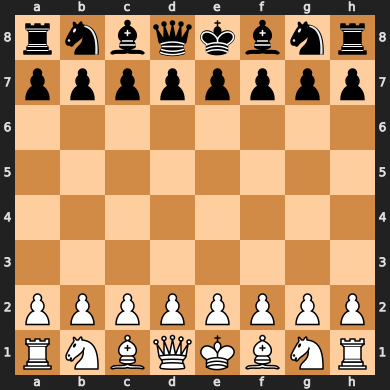

In [27]:
PlotaJogo(jogo_start)

In [28]:
def rock_grande(jogo_,cor='Brancas'):
    jogo = copy.deepcopy(jogo_)
    jogo = copy.deepcopy(movimento1('E1C1',jogo))
    jogo = copy.deepcopy(movimento1('A1D1',jogo))
    return jogo

def rock_pequeno(jogo_,cor='Brancas'):
    jogo = copy.deepcopy(jogo_)
    jogo = copy.deepcopy(movimento1('E1G1',jogo))
    jogo = copy.deepcopy(movimento1('H1F1',jogo))

In [29]:
casas = []
for i in tabuleiro_vazio:
    casas+=i

In [30]:
jogadas_possiveis2('C1',movimento1('D2D4',jogo_start),str)

['D2', 'E3', 'F4', 'G5', 'H6']

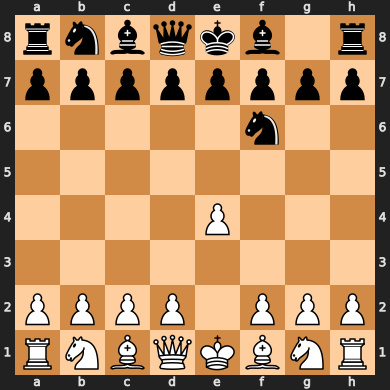

KeyboardInterrupt: 

In [31]:
# Executa jogo

Chess_pc_pc().play()